    # Strand to Strand Distance vs Radius

### Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import time
import sys
from collections import Counter
plt.style.use('seaborn-notebook')
plt.style.use('seaborn-whitegrid')

#Read in cmd line args

In [5]:
args = sys.argv
#args: script name, /path/to/.pdb, outfile path
args = ["script name", "/Users/davidboyer/Dropbox/Tau_Project_EISENBERG_LAB/amyloid_width/fixed_pdbs/6ufr_origin_5layers.pdb", "/Users/davidboyer/Dropbox/Tau_Project_EISENBERG_LAB/amyloid_width/python/temp_output/"]

### Functions

In [13]:
def get_file_length(input_file):
    with open(input_file) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def read_in_pdb(path):
    input_file = open(f'{path}','r')
    file_length = get_file_length(f'{path}')
    atom = []
    atomno = []
    nama = []
    resn = []
    chainid = []
    resida = []
    xa = []
    ya = []
    za = []
    occup = []
    tempf = []
    elem = []
    charge = []
    for lines in range(file_length):
        line = input_file.readline()
        if line[0:4] == 'ATOM':
            atom.append(line[0:6])
            atomno.append(line[6:11])
            nama.append(line[12:17])
            resn.append(line[17:20])
            chainid.append(line[21:22])
            resida.append(int(line[22:26]))
            xa.append(float(line[30:38]))
            ya.append(float(line[38:46]))
            za.append(float(line[46:54]))
            occup.append(line[54:60])
            tempf.append(line[60:66])
            elem.append(line[76:78])
            charge.append(line[78:80])
    d = {'Atom': atom, 'Atom Number': atomno, 'Atom Name': nama, 'Residue Name': resn, 'Chain ID': chainid, 'Residue Number': resida, 'X': xa, 'Y': ya, 'Z': za, 'Occupancy': occup, 'Temperature Factor': tempf, 'Element': elem, 'Charge': charge} 
    df = pd.DataFrame(d)
    input_file.close()
    return df

### Read-in from .pdb

In [38]:
filename =  args[1]
sample_name = args[1].split("/")[-1][0:4]
outpath = args[2]
make_outpath = f" mkdir -p {outpath} "
os.system(make_outpath)
df = read_in_pdb(filename)

### Calculations (Radius, Interstrand Distance)

In [30]:
#Get a list of the Chain IDs
temp = ['poop']
all_chain_IDs = [] 
num_chains = 0
num_atm_chn = 0
for i in df['Chain ID']:
    if temp != i:
        all_chain_IDs.append(i)
        temp = i
        num_chains += 1
        num_atm_chn = 0
    if temp == i:
        num_atm_chn += 1

In [34]:
#Calculate centers of mass for each chain
chainid, xa, ya, za = np.array(df['Chain ID']), np.array(df['X']), np.array(df['Y']), np.array(df['Z'])
length = len(chainid)
comx, comy, comz = [], [], []
for i in range(num_chains):
    sumx=0
    sumy=0
    sumz=0
    for j in range(length):
        if chainid[j] == all_chain_IDs[i]:
            sumx += (xa[j])
            sumy += (ya[j])
            sumz += (za[j])
    comx.append(sumx/num_atm_chn)
    comy.append(sumy/num_atm_chn)
    comz.append(sumz/num_atm_chn)


In [35]:
#Calculate all interstrand distances
resida, nama, resn = np.array(df['Residue Number']), np.array(df['Atom Name']), np.array(df['Residue Name'])
dist = []
radius = []
chain_ID_1 = []
chain_ID_2 = []
residue_number_12 = []
residue_name_12 = []
atom_name_12 = []
#start = time.time()
for i in range(num_chains):
    for j in range(i+1,num_chains):
        diffcomx=comx[i]-comx[j]
        diffcomy=comy[i]-comy[j]
        diffcomz=comz[i]-comz[j]
        diffcom=np.sqrt(diffcomx**2+diffcomy**2+diffcomz**2)
        if diffcom>0 and diffcom<5.2:
            print(all_chain_IDs[i],all_chain_IDs[j])
            for k in range(length):
                for l in range(length):
                    if resida[k]==resida[l] and nama[k]==nama[l] and resn[k]==resn[l] and chainid[k]==all_chain_IDs[i] and chainid[l]==all_chain_IDs[j]:
                        xak, xal, yak, yal, zak, zal = xa[k], xa[l], ya[k], ya[l], za[k], za[l]
                        disttemp = np.sqrt((xak-xal)**2+(yak-yal)**2+(zak-zal)**2)
                        dist.append(disttemp)
                        radius.append(np.sqrt(((xak**2+((yak)**2)))))
                        chain_ID_1.append(chainid[k])
                        chain_ID_2.append(chainid[l])
                        residue_number_12.append(resida[k])
                        atom_name_12.append(nama[k])
                        residue_name_12.append(resn[k])
#elapsed_time_fl = (time.time() - start)
#print(elapsed_time_fl)

A D
B C
C F
D E
E H
F G
G J
H I


In [36]:
#Calculate average interstrand distances
distavg=[]
radiusavg=[]
for i in range(num_atm_chn):
    matches=1
    distsum=dist[i]
    radiussum=radius[i]
    for j in range(num_atm_chn+1,len(dist)):
        if residue_name_12[i]==residue_name_12[j] and atom_name_12[i]==atom_name_12[j] and residue_number_12[i]==residue_number_12[j]:
            matches=matches+1
            distsum=dist[j]+distsum
            radiussum=radius[j]+radiussum
    distavg.append(distsum/matches)
    radiusavg.append(radiussum/matches)    
    

In [40]:
#Save radius, interstrand distance
with open(f'{outpath}{sample_name}' + str("_rad_dist.csv"),'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    for i in range(len(distavg)):
        row = [radius[i],distavg[i],chain_ID_1[i],chain_ID_2[i],atom_name_12[i],residue_name_12[i],residue_number_12[i],filename[0:4]]
        csv_writer.writerow(row)

### Graph Interstrand Distance versus Radius

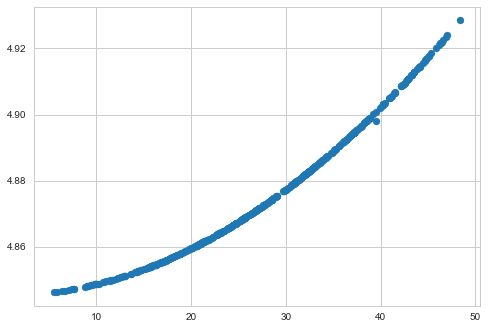

In [42]:
data=open(f'{outpath}{sample_name}' + str("_rad_dist.csv"))

data = np.genfromtxt(f'{outpath}{sample_name}' + str("_rad_dist.csv"), delimiter=",", names=["radius", "distance"])

plt.figure(1)
plt.scatter(data['radius'], data['distance'])